Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


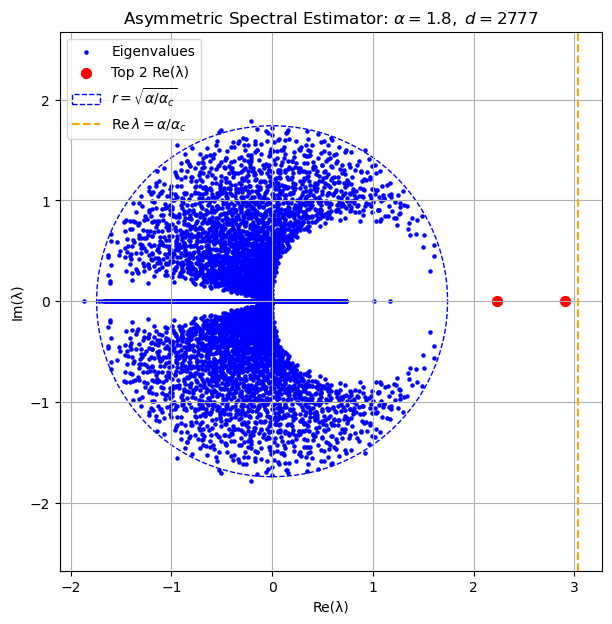

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Configuration
n = 5000        # number of samples
p = 2           # subspace dimension
alpha = 1.8
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate input matrix X ∈ ℝ^{n×d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Construct W* and observations Z = XW*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link: y = z1 × z2

# Compute preprocessing tensor G(y) ∈ ℝ^{n×p×p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # numerical stability

# Build G(y): per-sample 2×2 symmetric matrix
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Build asymmetric spectral matrix L ∈ ℝ^{np×np}
XXT = X @ X.T                      # (n, n)
XXT.fill_diagonal_(0.0)            # zero diagonal
A = XXT[:, :, None, None]          # (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]   # (1, n, p, p)
L_blocks = A * G_broadcast         # (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalues (GPU if available) and plot
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Top-2 by Re(λ)
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Figure settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


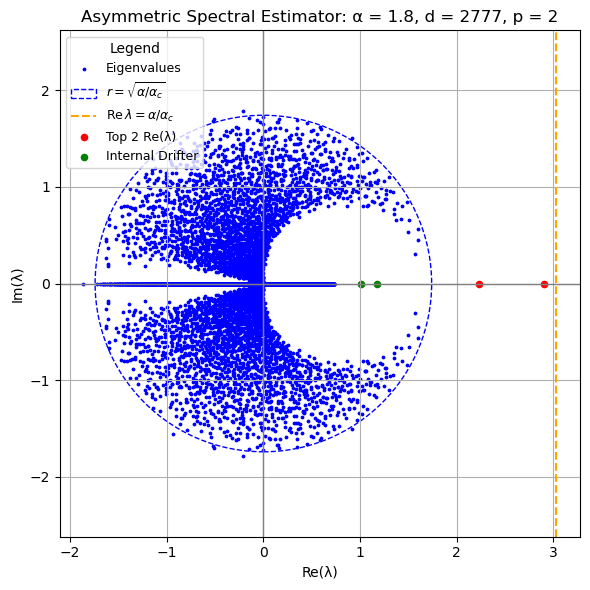

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Thresholds
R = np.sqrt(alpha / alpha_c)      # theoretical radius
thresh_ext = alpha / alpha_c      # vertical threshold line

# Select real eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red: top-2 eigenvalues by Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Green: top-2 internal points (Re < R)
green_candidates = [val for val in eigvals_real_only if val.real < R]
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:2]

# Plot spectrum
plt.figure(figsize=(6, 6))

# All eigenvalues (blue)
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Theoretical radius
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)

# Vertical threshold line
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red points (R1, R2)
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=20,
                label="Top 2 Re(λ)" if i == 0 else None)

# Green points (G1, G2)
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=20,
                label="Internal Drifter" if i == 0 else None)

# Axes and labels
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = {p}")
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr

# Generalized overlap evaluator
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # orthonormalize W*
    X_cpu = X.cpu().numpy().T  # (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)         # (n, 2)
        U = X_cpu @ V                    # (d, 2)

        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# Eigen-decomposition and arrays
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# Single-point overlaps
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# Aggregate results
all_results = results_red + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])

print(df_result)


      Label          Eigenvalue  Overlap_q
0  Green2-2  1.012436+0.000000j   0.186159
1  Green2-1  1.012436+0.000000j   0.186159
2  Green1-1  1.171297+0.000000j   0.170760
3  Green1-2  1.171297+0.000000j   0.170760
4    Red1-1  2.235321+0.000000j   0.147581
5    Red1-2  2.235321+0.000000j   0.147581
6    Red2-2  2.906451+0.000000j   0.142599
7    Red2-1  2.906451+0.000000j   0.142599


In [13]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# === 第二步：定义 rank-2 overlap 计算函数（不使用 Pt 编号）===
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # shape (d, n)

    v_map = {}  # Label -> 向量

    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # 通过 Label 末尾判断是第1还是第2个方向
        v_map[label] = V[:, j]

    # 枚举所有不重复组合
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape (d, 2)
        U, _ = qr(U, mode='economic')  # orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])\
             .sort_values("Rank2_Overlap_q", ascending=False)\
             .reset_index(drop=True)


# === 第三步：调用函数 ===
# 假设以下变量已存在：
# - W_star_np: (d, 2)
# - eigvals_np, eigvecs_np: 特征值与特征向量（来自 torch）
# - df_result: 包含单点标签 ["Label", "Eigenvalue", "Overlap_q"]
# - X: 输入矩阵 (n, d)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# === 第四步：输出结果 ===
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0   Green2-2 + Green1-1         0.357262
1   Green2-2 + Green1-2         0.357262
2   Green2-1 + Green1-1         0.357262
3   Green2-1 + Green1-2         0.357262
4     Green2-2 + Red1-1         0.334138
5     Green2-2 + Red1-2         0.334138
6     Green2-1 + Red1-2         0.334138
7     Green2-1 + Red1-1         0.334138
8     Green1-1 + Red2-1         0.313764
9     Green1-2 + Red2-1         0.313764
10    Green1-1 + Red2-2         0.313763
11    Green1-2 + Red2-2         0.313763
12      Red1-2 + Red2-1         0.290497
13      Red1-2 + Red2-2         0.290497
14      Red1-1 + Red2-1         0.290497
15      Red1-1 + Red2-2         0.290497
16  Green2-2 + Green2-1         0.238269
17    Green2-1 + Red2-2         0.188935
18    Green2-1 + Red2-1         0.188935
19    Green2-2 + Red2-2         0.188935
20    Green2-2 + Red2-1         0.188935
21    Green1-1 + Red1-1         0.177522
22    Green1-2 + Red1-2         0.177522
23    Green1-2 +

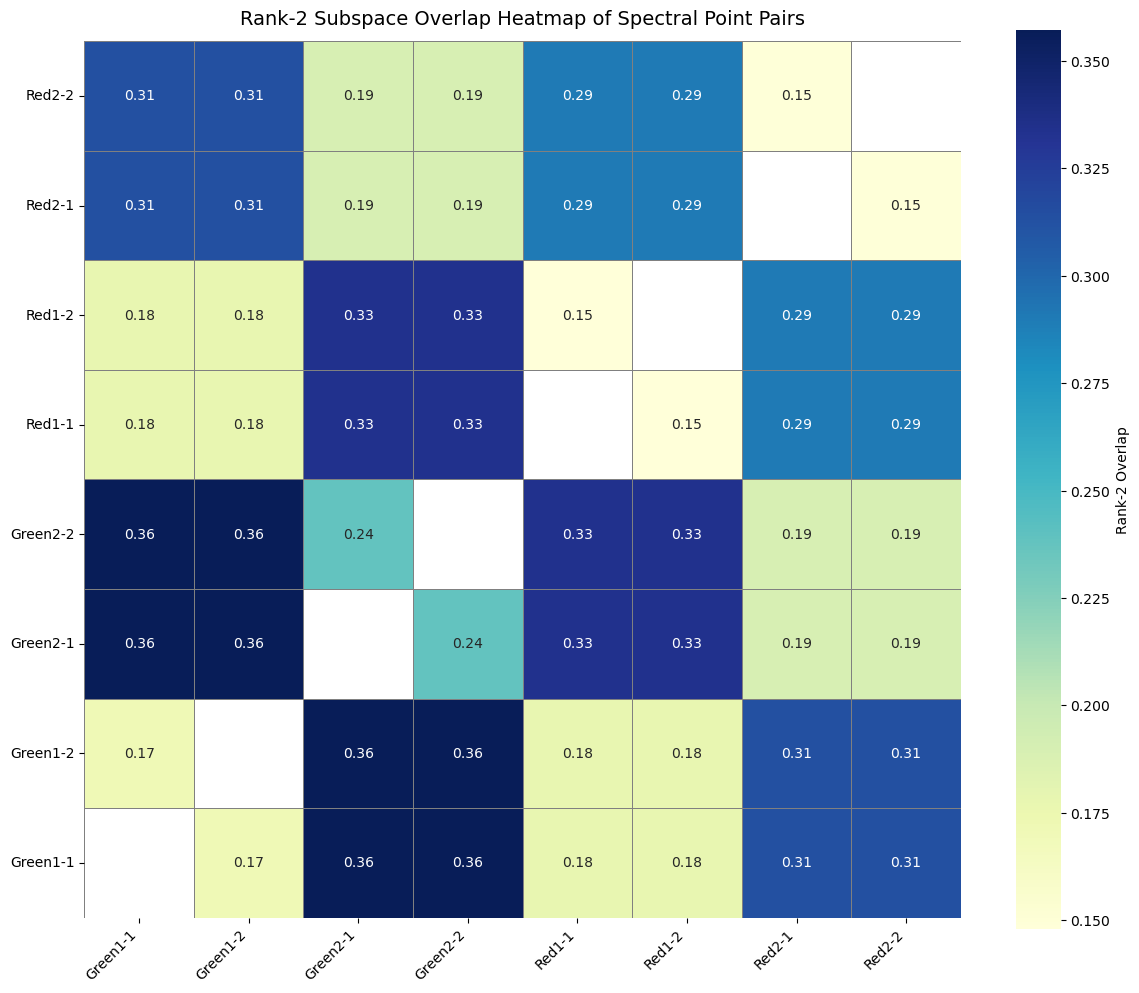

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# Rank-2 overlap calculation (using labels directly)
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # (d, n)

    v_map = {}  # Label -> vector

    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # (n, 2)
        j = 0 if '1' in label[-3:] else 1  # choose vector by label suffix
        v_map[label] = V[:, j]

    # Enumerate all unique pairs
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # (d, 2)
        U, _ = qr(U, mode='economic')          # orthonormalize
        q = norm(W_orth.T @ U, ord='fro')**2   # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False) \
             .reset_index(drop=True)

# Compute rank-2 overlaps
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# Display results
pd.set_option("display.max_rows", None)
print(df_rank2)


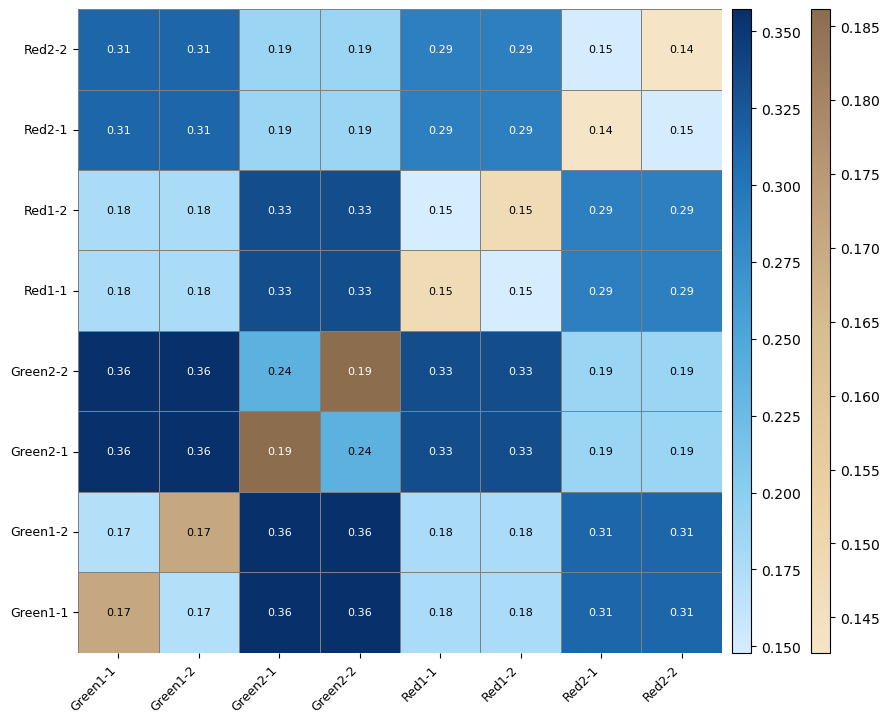

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# Build heatmap matrix
all_labels = sorted(set(df_result["Label"]))
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Fill rank-2 overlaps
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Fill rank-1 overlaps (diagonal)
for _, row in df_result.iterrows():
    label = row['Label']
    heatmap_matrix.loc[label, label] = row['Overlap_q']

# Masks for diagonal and off-diagonal
mask_rank1 = ~np.eye(len(all_labels), dtype=bool)
mask_rank2 = np.eye(len(all_labels), dtype=bool)

# Colormaps
cmap_rank2 = LinearSegmentedColormap.from_list("bright_blue_gradient", [
    "#D6ECFF", "#89CFF0", "#4CA5D9", "#2171B5", "#08306B"
])
cmap_rank1 = LinearSegmentedColormap.from_list("custom_rank1_softbrown", [
    "#F5E5C6", "#EBD0A4", "#D7BD92", "#B99876", "#8C6D4E"
])

# Value ranges
rank1_values = heatmap_matrix.values[np.eye(len(all_labels), dtype=bool)]
rank2_values = heatmap_matrix.values[~np.eye(len(all_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_values), np.nanmax(rank1_values)
rank2_min, rank2_max = np.nanmin(rank2_values), np.nanmax(rank2_values)

# Choose text color based on background brightness
def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

# Plot heatmap
fig, ax = plt.subplots(figsize=(9, 8))

# Off-diagonal: rank-2 overlaps
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank2,
    cmap=cmap_rank2,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Diagonal: rank-1 overlaps
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank1,
    cmap=cmap_rank1,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Add numerical labels
for i in range(len(all_labels)):
    for j in range(len(all_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}",
                ha='center', va='center', color=color, fontsize=8)

# Add two separate colorbars
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)

sm1 = ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max))
sm1.set_array([])
fig.colorbar(sm1, cax=cax1)

sm2 = ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max))
sm2.set_array([])
fig.colorbar(sm2, cax=cax2)

# Axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_12746/1408444067.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


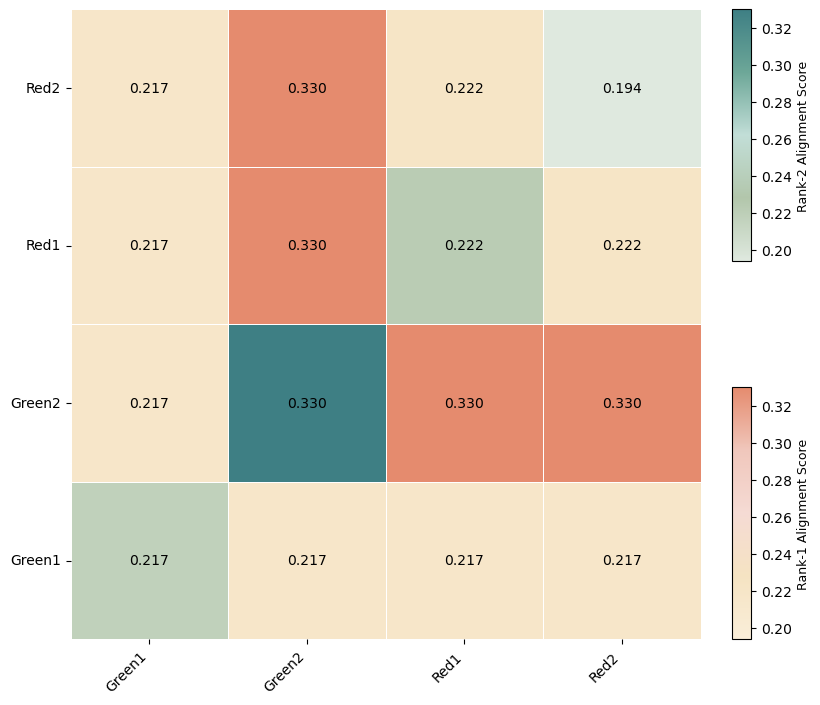

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Build heatmap data
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Fill diagonal (rank-1) scores
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# Fill off-diagonal (rank-2) scores
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # symmetry

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Colormaps
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Masks
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Value range
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Figure
fig, ax = plt.subplots(figsize=(8, 7))

# Plot off-diagonal (rank-2)
sns.heatmap(
    heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
    square=True, linewidths=0.5, cbar=False, ax=ax
)

# Compact colorbar (rank-2)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# Plot diagonal (rank-1)
sns.heatmap(
    heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
    square=True, linewidths=0.5, cbar=False, ax=ax
)

# Second colorbar (rank-1)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# Annotations
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# Styling
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()
